# Welcome to my Jupyter Notebook

In this Notebook I, Anouk Vreeburg, am going to work out the research question:

>How can a jazz song be created using generative deep learning?

<b>Why this question?</b><br>
Because I love older music styles and I love emerging technologies.<br>
I enjoy the world of Artificial Intelligence, Internet of Things, Virtual Reality and more up and coming tech related things. When I learned I could be doing a project with Artifical Intelligence combined with a creative aspect, I couldn't say no. I want to learn and code more about this world.<br>
I must admit, working with AI, with generative deep learning, is definitely a challenge, but one I gladly will take.

To make this question work, I plan to use the RNN/LSTM model. When I begin with preprocessing for this model, I will comment on it further. For now, this is the structure of this Notebook:
<ol>
    <li>Dataset</li>
    <li>Data cleaning</li>
    <li>Building the model</li>
    <li>Evaluation</li>
</ol>

<hr>

## Dataset

The first step: acquiring data<br>
For my question I am in need of a specific kind of data: midi jazz songs. As .mid is what I will be working with later when building the model. But... I didn't want to simply download a few jazz midi songs, I wanted to find more specific and close related jazz midi songs, so I went and found a jazz database online.

<font color="blue">https://jazzomat.hfm-weimar.de/dbformat/dbcontent.html</font><br>
I found this copyright free database online on the Jazzomat Research Project. This dataset was exactly what I was looking for, as it contains 450+ jazz songs and relevant columns about them.<br>

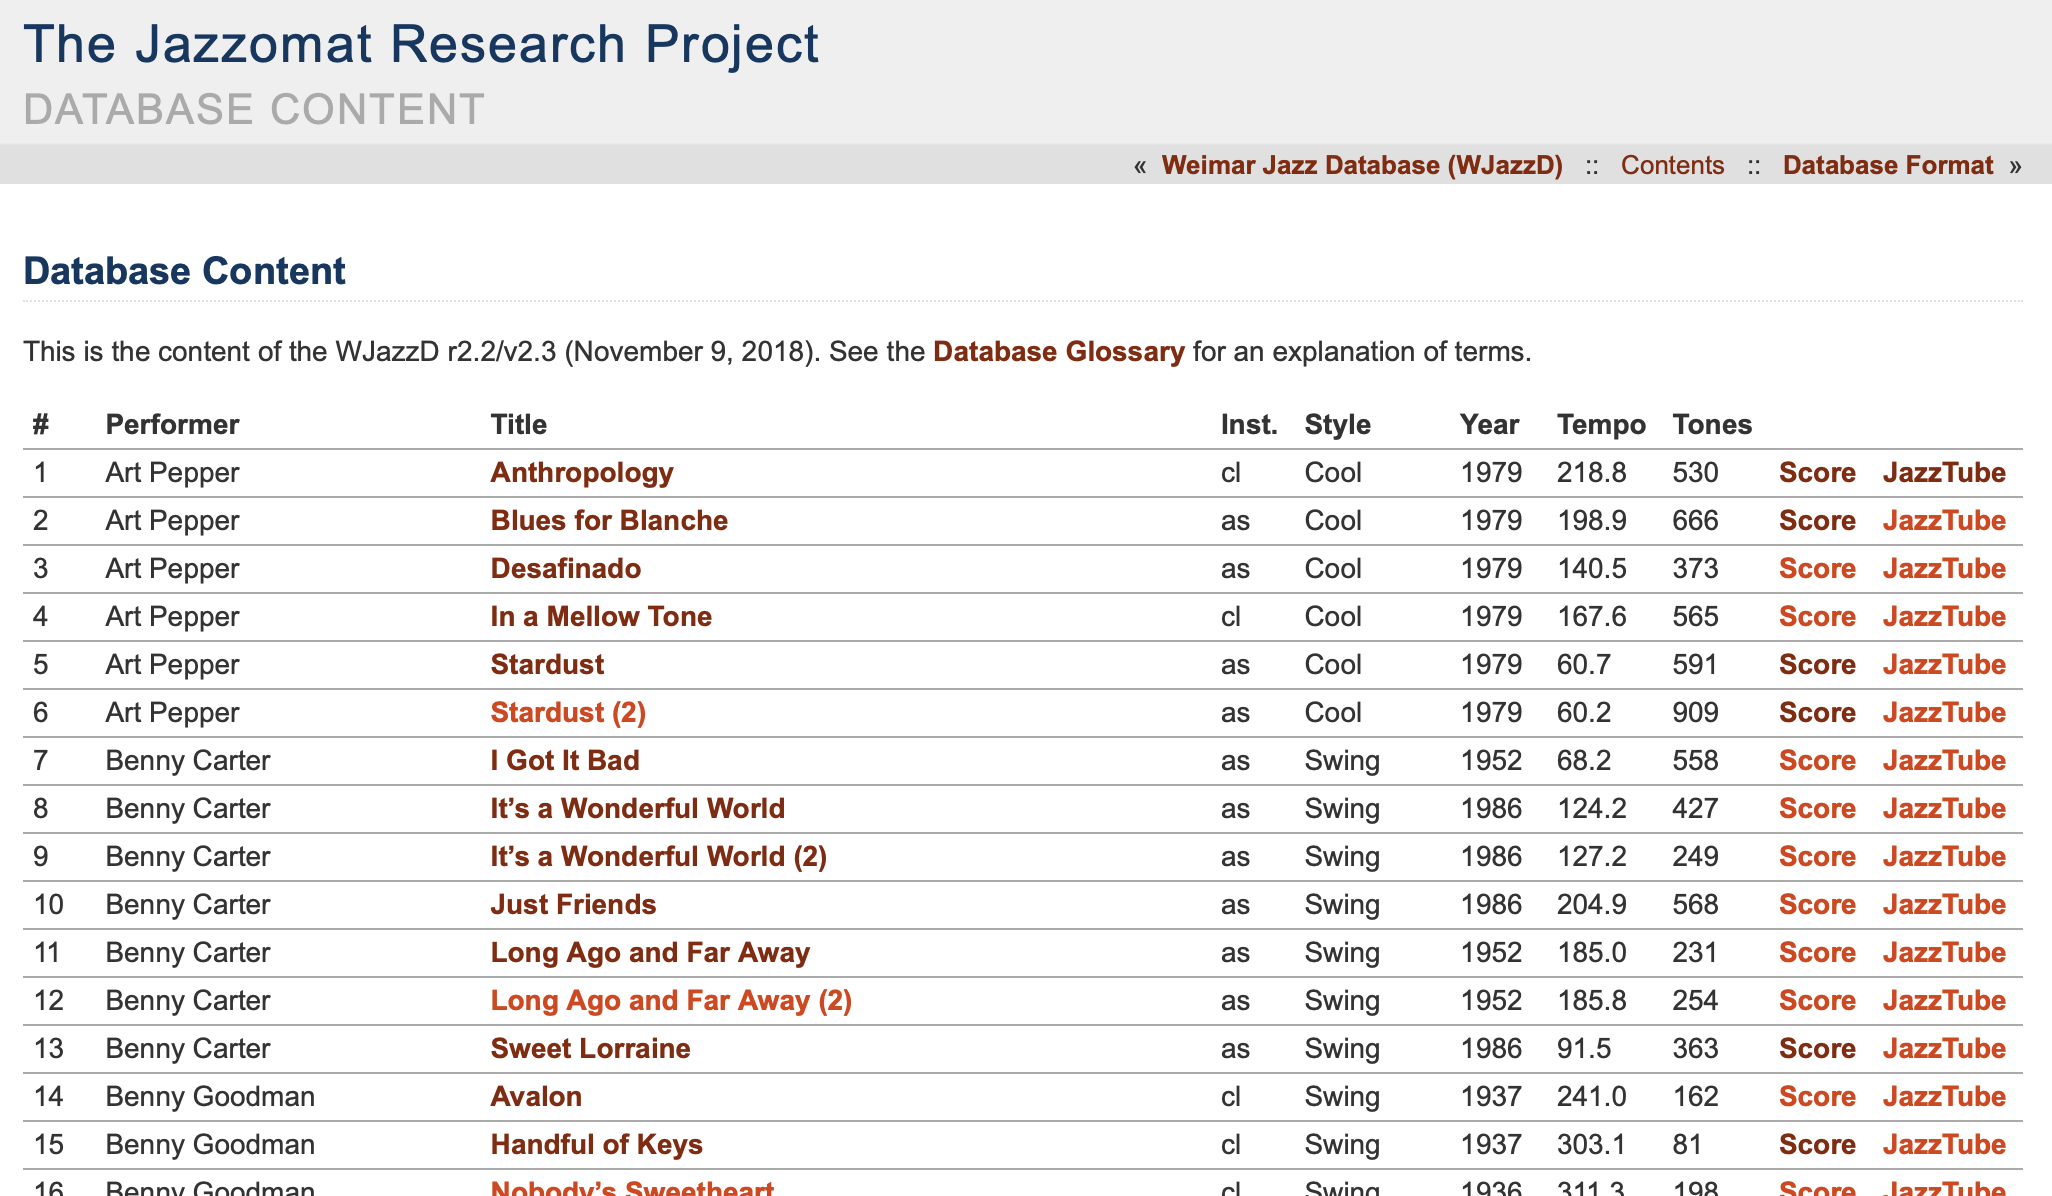

Furthermore, each jazz song also has its own page full of other relevant information that may come to be handy in exploratory data analysis.

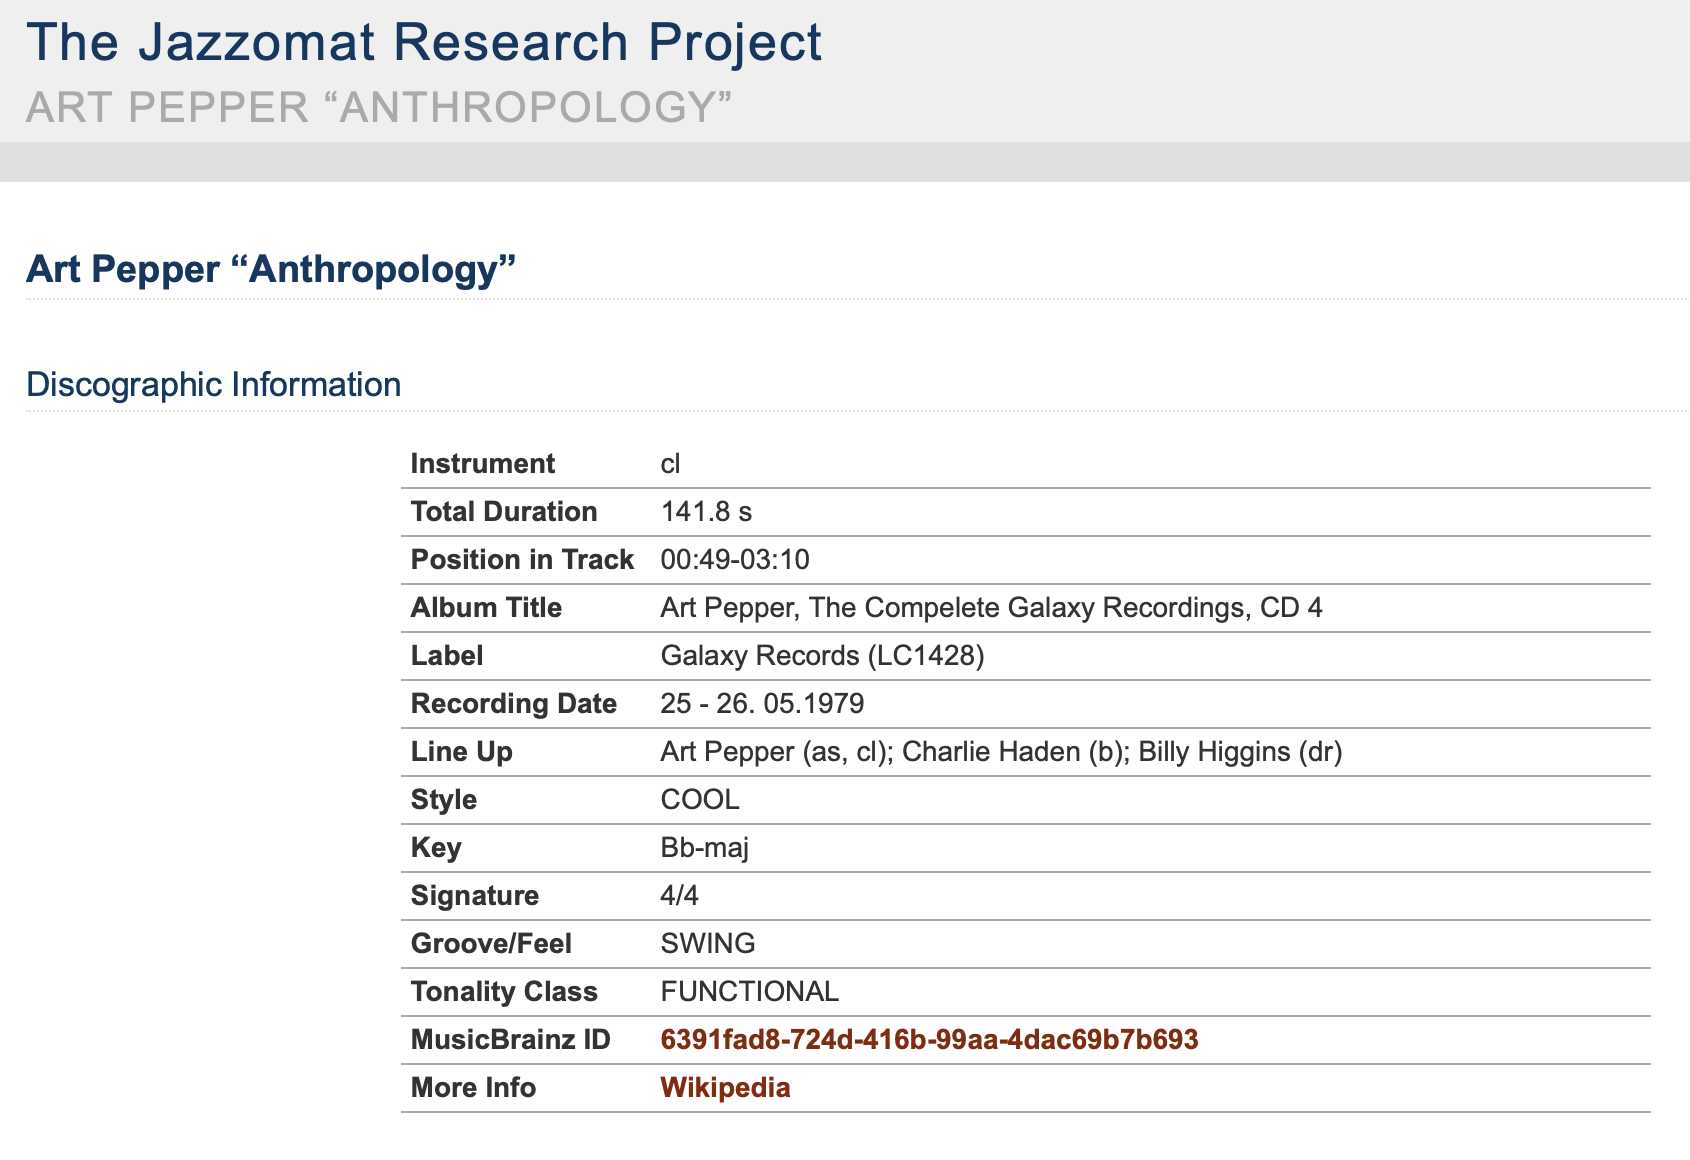

My plan is to webscrape their main page of songs and each song personal discographic information and statistics-features. I will collect everything I deem to be valuable when exploring the data. I will collect a lot of data this way about the songs, like their style, keys, instruments, duration, tempo and much more.<br><br>

I am doing this because I want the generative model to work at its best. I want to discover jazz songs that are very much related to each other, so the model will more easily produce its predictions. Exploratory data analysis will help me with finding the related songs. My goal is to have at least 100+, so the model will still have enough to work with.<br><br>
But before that can be done, I need to webscrape the data:

In [3]:
import requests
from bs4 import BeautifulSoup
import json

In [4]:
dataset = []

# I use a function for webscraping, because I need to use it twice. As songs 0, 2, 4 etc fall under "row-odd" and
# 1, 3, 5 etc under "row-even". I realize this could be done without a function, but a function was needed
# because "row-odd" started at 0, and 0 was not a row with a song but a row with the columns name. Therefore I
# needed a function because they are mostly the same, but needed a small difference in one part
def function (evenOrOdd, number):
    
    # activating webscraping overall page
    url = "https://jazzomat.hfm-weimar.de/dbformat/dbcontent.html"
    page = requests.get(url)
    html = BeautifulSoup(page.content, "html.parser")
    items = html.find_all("tr", class_=evenOrOdd)
    
    
    # I found help for how to skip the first element from this source: https://www.kite.com/python/answers/how-to-skip-the-first-element-of-a-for-loop-in-python
    for item in items[number:]:
        
        # getting all the information from the url above
        row = item.find_all("p")[0].get_text()
        performer = item.find_all("p")[1].get_text()
        title = item.find("a").get_text()
        instrument = item.find_all("p")[3].get_text()
        style = item.find_all("p")[4].get_text()
        year = item.find_all("p")[5].get_text()
        tempo = item.find_all("p")[6].get_text()
        numberofnotes = item.find_all("p")[7].get_text()

        # activating webscraping personal page 
        href = item.find("a")["href"]
        url2 = "https://jazzomat.hfm-weimar.de/dbformat/" + href
        page2 = requests.get(url2)
        html2 = BeautifulSoup(page2.content, "html.parser")
        items_even_2 = html2.find_all("tr", class_="row-even")
        items_odd_2 = html2.find_all("tr", class_="row-odd")

        totalduration = items_even_2[0].find_all("p")[1].get_text()
        # learned about when to use 'try and expect' from: https://stackoverflow.com/questions/16138232/is-it-a-good-practice-to-use-try-except-else-in-python
        # and https://stackoverflow.com/questions/33989354/list-index-out-of-range-while-data-scraping
        # when running this part, it gave an IndexError that two songs had a signature and a key missing, so it 
        # could not collect ("p").get_text. Because I knew the error was coming everytime, I solved it with try 
        # and expect
        try:
            key = items_odd_2[4].find_all("p")[1].get_text()
        except IndexError:
            key = "NaN"
        try:
            signature = items_even_2[4].find_all("p")[1].get_text()
        except IndexError:
            signature = "NaN"
        groovefeel = items_odd_2[5].find_all("p")[1].get_text()
        tonalityclass = items_even_2[5].find_all("p")[1].get_text()
        numberofbars = items_even_2[7].find_all("p")[1].get_text()
        numberofchoruses = items_odd_2[8].find_all("p")[1].get_text()
        meantempo = items_even_2[8].find_all("p")[1].get_text()
        eventdensity = items_odd_2[9].find_all("p")[1].get_text()
        metricaleventdensity = items_even_2[9].find_all("p")[1].get_text()
        medianswingratio = items_odd_2[10].find_all("p")[1].get_text()
        metricalcentroid = items_even_2[10].find_all("p")[1].get_text()
        syncopicity = items_odd_2[11].find_all("p")[1].get_text()
        ambitus = items_even_2[11].find_all("p")[1].get_text()
        extremaratio = items_odd_2[12].find_all("p")[1].get_text()
        
        # putting all the collected information together
        # row is a column with certainty I know only contains numbers, the rest will be made pretty in data cleaning
        rows = {"row": int(row), "performer": performer, "title": title, "instrument": instrument, "style": style,
                "year": (year), "tempo": (tempo), "number of notes": (numberofnotes), "duration": totalduration,
                "key": key, "signature": signature, "groove/feel": groovefeel, "tonality class": tonalityclass, 
                "number of bars": numberofbars, "number of choruses": (numberofchoruses), "mean tempo": meantempo,
                "event density": eventdensity, "metrical event density": metricaleventdensity, "median swing ratio": medianswingratio,
                "metrical centroid": metricalcentroid, "syncopicity": syncopicity, "ambitus": ambitus, 
                "extrema ratio": extremaratio}
        
        
        # putting all the rows in the empty dataset list
        dataset.append(rows)   
        
        # to check if all went well
        print(rows)

Activating the function:

In [5]:
# function has "evenOrOdd" because of the different rows as mentioned above and "number", because one row needs
# to skip the first one
function("row-even", 0)

function("row-odd", 1)

{'row': 1, 'performer': 'Art Pepper', 'title': 'Anthropology', 'instrument': 'cl', 'style': 'Cool', 'year': '1979', 'tempo': '218.8', 'number of notes': '530', 'duration': '141.8 s', 'key': 'Bb-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '129 bars', 'number of choruses': '4', 'mean tempo': '218.8 (UP)', 'event density': '3.74 Notes/s', 'metrical event density': '4.1 Notes/bar', 'median swing ratio': '1.37:1', 'metrical centroid': '3', 'syncopicity': '28.7 %', 'ambitus': '50-91 (41)', 'extrema ratio': '49.6 %'}
{'row': 3, 'performer': 'Art Pepper', 'title': 'Desafinado', 'instrument': 'as', 'style': 'Cool', 'year': '1979', 'tempo': '140.5', 'number of notes': '373', 'duration': '111.3 s', 'key': 'F-maj', 'signature': '4/4', 'groove/feel': 'LATIN', 'tonality class': 'FUNCTIONAL', 'number of bars': '65 bars', 'number of choruses': '2', 'mean tempo': '140.5 (MEDIUM UP)', 'event density': '3.35 Notes/s', 'metrical event density': '5.73

{'row': 33, 'performer': 'Bob Berg', 'title': 'I Didn’t Know What Time It Was', 'instrument': 'ts', 'style': 'Postbop', 'year': '1979', 'tempo': '126.7', 'number of notes': '906', 'duration': '203.8 s', 'key': 'F-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '108 bars', 'number of choruses': '3', 'mean tempo': '126.7 (MEDIUM)', 'event density': '4.45 Notes/s', 'metrical event density': '8.41 Notes/bar', 'median swing ratio': '1.62:1', 'metrical centroid': '4', 'syncopicity': '39.1 %', 'ambitus': '45-79 (34)', 'extrema ratio': '38.7 %'}
{'row': 35, 'performer': 'Bob Berg', 'title': 'No Moe', 'instrument': 'ts', 'style': 'Postbop', 'year': '1993', 'tempo': '161.8', 'number of notes': '633', 'duration': '137.9 s', 'key': 'Bb-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '93 bars', 'number of choruses': '2', 'mean tempo': '161.8 (MEDIUM UP)', 'event density': '4.59 Notes/s', 'metrica

{'row': 65, 'performer': 'Charlie Parker', 'title': 'Star Eyes', 'instrument': 'as', 'style': 'Bebop', 'year': '1950', 'tempo': '133.8', 'number of notes': '314', 'duration': '65.2 s', 'key': 'Eb-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '36 bars', 'number of choruses': '1', 'mean tempo': '133.8 (MEDIUM)', 'event density': '4.81 Notes/s', 'metrical event density': '8.64 Notes/bar', 'median swing ratio': '1.67:1', 'metrical centroid': '3+', 'syncopicity': '45.5 %', 'ambitus': '55-79 (24)', 'extrema ratio': '38.2 %'}
{'row': 67, 'performer': 'Charlie Parker', 'title': 'Thriving on a Riff', 'instrument': 'as', 'style': 'Bebop', 'year': '1945', 'tempo': '227.2', 'number of notes': '357', 'duration': '68.3 s', 'key': 'Bb-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '65 bars', 'number of choruses': '2', 'mean tempo': '227.2 (UP)', 'event density': '5.23 Notes/s', 'metrical event d

{'row': 97, 'performer': 'Coleman Hawkins', 'title': 'It’s Only a Papermoon', 'instrument': 'ts', 'style': 'Swing', 'year': '1949', 'tempo': '133.7', 'number of notes': '257', 'duration': '57.7 s', 'key': 'F-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '32 bars', 'number of choruses': '1', 'mean tempo': '133.7 (MEDIUM)', 'event density': '4.45 Notes/s', 'metrical event density': '8.0 Notes/bar', 'median swing ratio': '1.57:1', 'metrical centroid': '2+', 'syncopicity': '33.1 %', 'ambitus': '47-72 (25)', 'extrema ratio': '37.7 %'}
{'row': 99, 'performer': 'Coleman Hawkins', 'title': 'Perdido', 'instrument': 'ts', 'style': 'Swing', 'year': '1950', 'tempo': '177.5', 'number of notes': '468', 'duration': '89.0 s', 'key': 'Bb-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '66 bars', 'number of choruses': '2', 'mean tempo': '177.5 (MEDIUM UP)', 'event density': '5.26 Notes/s', 'metrical

{'row': 129, 'performer': 'Dickie Wells', 'title': 'Dickie’s Dream', 'instrument': 'tb', 'style': 'Swing', 'year': '1939', 'tempo': '229.4', 'number of notes': '109', 'duration': '31.8 s', 'key': 'C-min', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '30 bars', 'number of choruses': '1', 'mean tempo': '229.4 (UP)', 'event density': '3.43 Notes/s', 'metrical event density': '3.6 Notes/bar', 'median swing ratio': '1.35:1', 'metrical centroid': '1', 'syncopicity': '26.6 %', 'ambitus': '53-72 (19)', 'extrema ratio': '32.1 %'}
{'row': 131, 'performer': 'Dickie Wells', 'title': 'Jo-Jo', 'instrument': 'tb', 'style': 'Swing', 'year': '1944', 'tempo': '183.4', 'number of notes': '114', 'duration': '31.6 s', 'key': 'Bb-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'BLUES', 'number of bars': '24 bars', 'number of choruses': '2', 'mean tempo': '183.4 (UP)', 'event density': '3.6 Notes/s', 'metrical event density': '4.72 Notes/ba

{'row': 161, 'performer': 'Fats Navarro', 'title': 'Good Bait (Alternate Take)', 'instrument': 'tp', 'style': 'Bebop', 'year': '1948', 'tempo': '146.2', 'number of notes': '261', 'duration': '53.2 s', 'key': 'Bb-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '32 bars', 'number of choruses': '1', 'mean tempo': '146.2 (MEDIUM UP)', 'event density': '4.91 Notes/s', 'metrical event density': '8.06 Notes/bar', 'median swing ratio': '1.8:1', 'metrical centroid': '2+', 'syncopicity': '39.5 %', 'ambitus': '59-84 (25)', 'extrema ratio': '41.0 %'}
{'row': 163, 'performer': 'Fats Navarro', 'title': 'Our Delight', 'instrument': 'tp', 'style': 'Bebop', 'year': '1948', 'tempo': '200.7', 'number of notes': '208', 'duration': '38.5 s', 'key': 'Ab-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '32 bars', 'number of choruses': '1', 'mean tempo': '200.7 (UP)', 'event density': '5.4 Notes/s', 'metrica

{'row': 193, 'performer': 'J.J. Johnson', 'title': 'Elora', 'instrument': 'tb', 'style': 'Bebop', 'year': '1949', 'tempo': '196.9', 'number of notes': '140', 'duration': '38.9 s', 'key': 'Bb-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '32 bars', 'number of choruses': '1', 'mean tempo': '196.9 (UP)', 'event density': '3.6 Notes/s', 'metrical event density': '4.37 Notes/bar', 'median swing ratio': '1.52:1', 'metrical centroid': '2', 'syncopicity': '36.4 %', 'ambitus': '50-74 (24)', 'extrema ratio': '36.4 %'}
{'row': 195, 'performer': 'J.J. Johnson', 'title': 'Teapot', 'instrument': 'tb', 'style': 'Bebop', 'year': '1949', 'tempo': '315.2', 'number of notes': '251', 'duration': '48.8 s', 'key': 'F-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '64 bars', 'number of choruses': '2', 'mean tempo': '315.2 (UP)', 'event density': '5.15 Notes/s', 'metrical event density': '3.92 Notes/bar'

{'row': 225, 'performer': 'John Coltrane', 'title': 'Impressions (1963)', 'instrument': 'ts', 'style': 'Postbop', 'year': '1963', 'tempo': '278.7', 'number of notes': '1954', 'duration': '370.3 s', 'key': 'D-min', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'MODAL', 'number of bars': '430 bars', 'number of choruses': '13', 'mean tempo': '278.7 (UP)', 'event density': '5.28 Notes/s', 'metrical event density': '4.54 Notes/bar', 'median swing ratio': '1.33:1', 'metrical centroid': '4', 'syncopicity': '23.0 %', 'ambitus': '41-83 (42)', 'extrema ratio': '49.2 %'}
{'row': 227, 'performer': 'John Coltrane', 'title': 'My Favorite Things', 'instrument': 'ss', 'style': 'Postbop', 'year': '1960', 'tempo': '179.3', 'number of notes': '743', 'duration': '141.9 s', 'key': 'E-min', 'signature': '3/4', 'groove/feel': 'SWING', 'tonality class': 'MODAL', 'number of bars': '141 bars', 'number of choruses': '1', 'mean tempo': '179.3 (MEDIUM UP)', 'event density': '5.24 Notes/s', 'metrica

{'row': 257, 'performer': 'Kenny Garrett', 'title': 'Brother Hubbard (2)', 'instrument': 'as', 'style': 'Fusion', 'year': '1997', 'tempo': '143.2', 'number of notes': '452', 'duration': '108.0 s', 'key': 'D-min', 'signature': '4/4', 'groove/feel': 'FUNK', 'tonality class': 'COLOR', 'number of bars': '64 bars', 'number of choruses': '2', 'mean tempo': '143.2 (MEDIUM UP)', 'event density': '4.18 Notes/s', 'metrical event density': '7.02 Notes/bar', 'median swing ratio': '1.37:1', 'metrical centroid': '1', 'syncopicity': '30.1 %', 'ambitus': '51-86 (35)', 'extrema ratio': '39.2 %'}
{'row': 259, 'performer': 'Kenny Wheeler', 'title': 'Pass It On', 'instrument': 'tp', 'style': 'Fusion', 'year': '1991', 'tempo': '105.7', 'number of notes': '264', 'duration': '70.0 s', 'key': 'C-min', 'signature': '4/4', 'groove/feel': 'FUNK', 'tonality class': 'MODAL', 'number of bars': '31 bars', 'number of choruses': '2', 'mean tempo': '105.7 (MEDIUM SLOW)', 'event density': '3.77 Notes/s', 'metrical event

{'row': 289, 'performer': 'Lionel Hampton', 'title': 'Runnin’ Wild', 'instrument': 'vib', 'style': 'Swing', 'year': '1937', 'tempo': '281.1', 'number of notes': '164', 'duration': '26.3 s', 'key': 'Bb-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '31 bars', 'number of choruses': '1', 'mean tempo': '281.1 (UP)', 'event density': '6.23 Notes/s', 'metrical event density': '5.32 Notes/bar', 'median swing ratio': '1.05:1', 'metrical centroid': '2', 'syncopicity': '7.9 %', 'ambitus': '55-89 (34)', 'extrema ratio': '42.1 %'}
{'row': 291, 'performer': 'Louis Armstrong', 'title': 'Basin Street Blues', 'instrument': 'tp', 'style': 'Traditional', 'year': '1928', 'tempo': '107.2', 'number of notes': '219', 'duration': '67.2 s', 'key': 'Bb-maj', 'signature': '4/4', 'groove/feel': 'TWOBEAT', 'tonality class': 'BLUES', 'number of bars': '30 bars', 'number of choruses': '3', 'mean tempo': '107.2 (MEDIUM SLOW)', 'event density': '3.26 Notes/s', 'met

{'row': 321, 'performer': 'Miles Davis', 'title': 'Oleo (2)', 'instrument': 'tp', 'style': 'Hardbop', 'year': '1956', 'tempo': '268.0', 'number of notes': '223', 'duration': '55.3 s', 'key': 'Bb-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '62 bars', 'number of choruses': '2', 'mean tempo': '268.0 (UP)', 'event density': '4.04 Notes/s', 'metrical event density': '3.61 Notes/bar', 'median swing ratio': '1.21:1', 'metrical centroid': '3', 'syncopicity': '15.2 %', 'ambitus': '52-82 (30)', 'extrema ratio': '42.2 %'}
{'row': 323, 'performer': 'Miles Davis', 'title': 'So What', 'instrument': 'tp', 'style': 'Postbop', 'year': '1959', 'tempo': '138.5', 'number of notes': '221', 'duration': '112.1 s', 'key': 'D-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'MODAL', 'number of bars': '65 bars', 'number of choruses': '2', 'mean tempo': '138.5 (MEDIUM)', 'event density': '1.97 Notes/s', 'metrical event density': '3.42 Not

{'row': 353, 'performer': 'Paul Desmond', 'title': 'The Girl from East 9th Street', 'instrument': 'as', 'style': 'Cool', 'year': '1964', 'tempo': '142.1', 'number of notes': '272', 'duration': '108.8 s', 'key': 'Ab-maj', 'signature': '4/4', 'groove/feel': 'LATIN', 'tonality class': 'FUNCTIONAL', 'number of bars': '64 bars', 'number of choruses': '2', 'mean tempo': '142.1 (MEDIUM UP)', 'event density': '2.5 Notes/s', 'metrical event density': '4.22 Notes/bar', 'median swing ratio': '1.49:1', 'metrical centroid': '4', 'syncopicity': '26.8 %', 'ambitus': '57-79 (22)', 'extrema ratio': '37.5 %'}
{'row': 355, 'performer': 'Pepper Adams', 'title': 'Early Morning Mood', 'instrument': 'bs', 'style': 'Hardbop', 'year': '1958', 'tempo': '59.8', 'number of notes': '366', 'duration': '95.9 s', 'key': 'G-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'BLUES', 'number of bars': '24 bars', 'number of choruses': '3', 'mean tempo': '59.8 (SLOW)', 'event density': '3.82 Notes/s', 'm

{'row': 385, 'performer': 'Sonny Rollins', 'title': 'St. Thomas', 'instrument': 'ts', 'style': 'Hardbop', 'year': '1956', 'tempo': '207.0', 'number of notes': '435', 'duration': '92.5 s', 'key': 'C-maj', 'signature': '4/4', 'groove/feel': 'LATIN', 'tonality class': 'FUNCTIONAL', 'number of bars': '80 bars', 'number of choruses': '5', 'mean tempo': '207.0 (UP)', 'event density': '4.7 Notes/s', 'metrical event density': '5.44 Notes/bar', 'median swing ratio': '1.36:1', 'metrical centroid': '3', 'syncopicity': '31.0 %', 'ambitus': '44-76 (32)', 'extrema ratio': '48.5 %'}
{'row': 387, 'performer': 'Sonny Rollins', 'title': 'Tenor Madness', 'instrument': 'ts', 'style': 'Hardbop', 'year': '1956', 'tempo': '175.6', 'number of notes': '507', 'duration': '130.6 s', 'key': 'Bb-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'BLUES', 'number of bars': '96 bars', 'number of choruses': '8', 'mean tempo': '175.6 (MEDIUM UP)', 'event density': '3.88 Notes/s', 'metrical event densi

{'row': 417, 'performer': 'Steve Lacy', 'title': 'Skippy', 'instrument': 'ss', 'style': 'Hardbop', 'year': '1958', 'tempo': '266.8', 'number of notes': '582', 'duration': '86.6 s', 'key': 'Ab-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '96 bars', 'number of choruses': '3', 'mean tempo': '266.8 (UP)', 'event density': '6.72 Notes/s', 'metrical event density': '6.05 Notes/bar', 'median swing ratio': '1.28:1', 'metrical centroid': '1+', 'syncopicity': '16.8 %', 'ambitus': '58-86 (28)', 'extrema ratio': '36.1 %'}
{'row': 419, 'performer': 'Steve Turre', 'title': 'Dat Dere', 'instrument': 'tb', 'style': 'Postbop', 'year': '1987', 'tempo': '116.0', 'number of notes': '520', 'duration': '131.7 s', 'key': 'C-min', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '64 bars', 'number of choruses': '3', 'mean tempo': '116.0 (MEDIUM)', 'event density': '3.95 Notes/s', 'metrical event density': '8.18

{'row': 449, 'performer': 'Wynton Marsalis', 'title': 'U.M.M.G.', 'instrument': 'tp', 'style': 'Postbop', 'year': '1991', 'tempo': '221.3', 'number of notes': '261', 'duration': '70.0 s', 'key': 'Db-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '64 bars', 'number of choruses': '2', 'mean tempo': '221.3 (UP)', 'event density': '3.73 Notes/s', 'metrical event density': '4.05 Notes/bar', 'median swing ratio': '1.68:1', 'metrical centroid': '4', 'syncopicity': '23.4 %', 'ambitus': '60-84 (24)', 'extrema ratio': '46.7 %'}
{'row': 451, 'performer': 'Zoot Sims', 'title': 'All the Things You Are', 'instrument': 'ts', 'style': 'Cool', 'year': '1950', 'tempo': '192.2', 'number of notes': '176', 'duration': '46.4 s', 'key': 'Ab-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '37 bars', 'number of choruses': '1', 'mean tempo': '192.2 (UP)', 'event density': '3.8 Notes/s', 'metrical event densi

{'row': 26, 'performer': 'Bix Beiderbecke', 'title': 'I’m Coming Virginia', 'instrument': 'cor', 'style': 'Traditional', 'year': '1927', 'tempo': '131.5', 'number of notes': '225', 'duration': '88.2 s', 'key': 'F-maj', 'signature': '4/4', 'groove/feel': 'TWOBEAT', 'tonality class': 'FUNCTIONAL', 'number of bars': '48 bars', 'number of choruses': '2', 'mean tempo': '131.5 (MEDIUM)', 'event density': '2.55 Notes/s', 'metrical event density': '4.66 Notes/bar', 'median swing ratio': '1.43:1', 'metrical centroid': '2', 'syncopicity': '25.3 %', 'ambitus': '58-81 (23)', 'extrema ratio': '46.2 %'}
{'row': 28, 'performer': 'Bix Beiderbecke', 'title': 'Riverboat Shuffle', 'instrument': 'cor', 'style': 'Traditional', 'year': '1927', 'tempo': '210.9', 'number of notes': '161', 'duration': '36.7 s', 'key': 'Ab-maj', 'signature': '4/4', 'groove/feel': 'TWOBEAT', 'tonality class': 'FUNCTIONAL', 'number of bars': '32 bars', 'number of choruses': '1', 'mean tempo': '210.9 (UP)', 'event density': '4.39 

{'row': 58, 'performer': 'Charlie Parker', 'title': 'K.C. Blues', 'instrument': 'as', 'style': 'Bebop', 'year': '1951', 'tempo': '118.3', 'number of notes': '196', 'duration': '51.0 s', 'key': 'C-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'BLUES', 'number of bars': '25 bars', 'number of choruses': '2', 'mean tempo': '118.3 (MEDIUM)', 'event density': '3.84 Notes/s', 'metrical event density': '7.78 Notes/bar', 'median swing ratio': '1.88:1', 'metrical centroid': '1', 'syncopicity': '45.4 %', 'ambitus': '53-78 (25)', 'extrema ratio': '45.4 %'}
{'row': 60, 'performer': 'Charlie Parker', 'title': 'My Little Suede Shoes', 'instrument': 'as', 'style': 'Bebop', 'year': '1951', 'tempo': '145.9', 'number of notes': '256', 'duration': '53.3 s', 'key': 'Eb-maj', 'signature': '4/4', 'groove/feel': 'LATIN', 'tonality class': 'FUNCTIONAL', 'number of bars': '32 bars', 'number of choruses': '1', 'mean tempo': '145.9 (MEDIUM UP)', 'event density': '4.8 Notes/s', 'metrical even

{'row': 90, 'performer': 'Clifford Brown', 'title': 'I’ll Remember April (Alternate Take 2)', 'instrument': 'tp', 'style': 'Hardbop', 'year': '1956', 'tempo': '291.5', 'number of notes': '573', 'duration': '80.4 s', 'key': 'G-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '98 bars', 'number of choruses': '2', 'mean tempo': '291.5 (UP)', 'event density': '7.13 Notes/s', 'metrical event density': '5.86 Notes/bar', 'median swing ratio': '1.08:1', 'metrical centroid': '3+', 'syncopicity': '33.5 %', 'ambitus': '53-81 (28)', 'extrema ratio': '30.0 %'}
{'row': 92, 'performer': 'Clifford Brown', 'title': 'Jordu', 'instrument': 'tp', 'style': 'Hardbop', 'year': '1954', 'tempo': '139.0', 'number of notes': '552', 'duration': '110.2 s', 'key': 'Eb-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '64 bars', 'number of choruses': '2', 'mean tempo': '139.0 (MEDIUM)', 'event density': '5.01 Notes/s

{'row': 118, 'performer': 'David Murray', 'title': 'Body and Soul', 'instrument': 'ts', 'style': 'Postbop', 'year': '1983', 'tempo': '65.9', 'number of notes': '564', 'duration': '118.7 s', 'key': 'Db-maj', 'signature': '4/4', 'groove/feel': 'BALLAD', 'tonality class': 'FUNCTIONAL', 'number of bars': '33 bars', 'number of choruses': '1', 'mean tempo': '65.9 (SLOW)', 'event density': '4.75 Notes/s', 'metrical event density': '17.28 Notes/bar', 'median swing ratio': '0.67:1', 'metrical centroid': '1', 'syncopicity': '45.4 %', 'ambitus': '44-88 (44)', 'extrema ratio': '47.2 %'}
{'row': 120, 'performer': 'David Murray', 'title': 'Chelsea Bridge', 'instrument': 'ts', 'style': 'Postbop', 'year': '1990', 'tempo': '53.0', 'number of notes': '588', 'duration': '149.7 s', 'key': 'Db-maj', 'signature': '4/4', 'groove/feel': 'BALLAD', 'tonality class': 'FUNCTIONAL', 'number of bars': '33 bars', 'number of choruses': '1', 'mean tempo': '53.0 (SLOW)', 'event density': '3.93 Notes/s', 'metrical event

{'row': 148, 'performer': 'Don Ellis', 'title': 'Johnny Come Lately', 'instrument': 'tp', 'style': 'Postbop', 'year': '1962', 'tempo': '211.3', 'number of notes': '298', 'duration': '74.2 s', 'key': 'G-min', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '65 bars', 'number of choruses': '2', 'mean tempo': '211.3 (UP)', 'event density': '4.02 Notes/s', 'metrical event density': '4.56 Notes/bar', 'median swing ratio': '1.53:1', 'metrical centroid': '4', 'syncopicity': '22.1 %', 'ambitus': '55-87 (32)', 'extrema ratio': '39.6 %'}
{'row': 150, 'performer': 'Don Ellis', 'title': 'Sweet and Lovely', 'instrument': 'tp', 'style': 'Postbop', 'year': '1961', 'tempo': '134.1', 'number of notes': '331', 'duration': '115.4 s', 'key': 'C-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '65 bars', 'number of choruses': '2', 'mean tempo': '134.1 (MEDIUM)', 'event density': '2.87 Notes/s', 'metrical event 

{'row': 180, 'performer': 'Hank Mobley', 'title': 'Remember', 'instrument': 'ts', 'style': 'Hardbop', 'year': '1960', 'tempo': '165.9', 'number of notes': '633', 'duration': '141.8 s', 'key': 'Ab-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '98 bars', 'number of choruses': '3', 'mean tempo': '165.9 (MEDIUM UP)', 'event density': '4.46 Notes/s', 'metrical event density': '6.46 Notes/bar', 'median swing ratio': '1.59:1', 'metrical centroid': '4+', 'syncopicity': '32.7 %', 'ambitus': '47-75 (28)', 'extrema ratio': '35.9 %'}
{'row': 182, 'performer': 'Harry Edison', 'title': 'Did You Call Her Today', 'instrument': 'tp', 'style': 'Swing', 'year': '1962', 'tempo': '118.5', 'number of notes': '366', 'duration': '133.2 s', 'key': 'Ab-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '66 bars', 'number of choruses': '2', 'mean tempo': '118.5 (MEDIUM)', 'event density': '2.75 Notes/s', 'metri

{'row': 212, 'performer': 'Joe Lovano', 'title': 'Lonnie’s Lament', 'instrument': 'ts', 'style': 'Postbop', 'year': '1994', 'tempo': '201.0', 'number of notes': '862', 'duration': '193.5 s', 'key': 'C-min', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '162 bars', 'number of choruses': '11', 'mean tempo': '201.0 (UP)', 'event density': '4.45 Notes/s', 'metrical event density': '5.32 Notes/bar', 'median swing ratio': '1.72:1', 'metrical centroid': '3', 'syncopicity': '31.7 %', 'ambitus': '43-86 (43)', 'extrema ratio': '44.9 %'}
{'row': 214, 'performer': 'John Abercrombie', 'title': 'Ralph’s Piano Waltz', 'instrument': 'g', 'style': 'Postbop', 'year': '1988', 'tempo': '196.5', 'number of notes': '298', 'duration': '78.8 s', 'key': 'NaN', 'signature': '3/4', 'groove/feel': 'SWING', 'tonality class': 'MODAL', 'number of bars': '86 bars', 'number of choruses': '3', 'mean tempo': '196.5 (UP)', 'event density': '3.78 Notes/s', 'metrical event de

{'row': 244, 'performer': 'Joshua Redman', 'title': 'Home Fries', 'instrument': 'ts', 'style': 'Postbop', 'year': '1996', 'tempo': '181.4', 'number of notes': '590', 'duration': '128.6 s', 'key': 'Eb-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'BLUES', 'number of bars': '97 bars', 'number of choruses': '6', 'mean tempo': '181.4 (UP)', 'event density': '4.59 Notes/s', 'metrical event density': '6.07 Notes/bar', 'median swing ratio': '1.46:1', 'metrical centroid': '4', 'syncopicity': '28.3 %', 'ambitus': '45-86 (41)', 'extrema ratio': '39.2 %'}
{'row': 246, 'performer': 'Joshua Redman', 'title': 'Sweet Sorrow', 'instrument': 'ts', 'style': 'Postbop', 'year': '1994', 'tempo': '53.0', 'number of notes': '502', 'duration': '163.6 s', 'key': 'G-min', 'signature': '6/8', 'groove/feel': 'BALLAD', 'tonality class': 'COLOR', 'number of bars': '36 bars', 'number of choruses': '1', 'mean tempo': '53.0 (SLOW)', 'event density': '3.07 Notes/s', 'metrical event density': '13.8

{'row': 276, 'performer': 'Lee Morgan', 'title': 'The Sidewinder', 'instrument': 'tp', 'style': 'Hardbop', 'year': '1963', 'tempo': '156.3', 'number of notes': '396', 'duration': '112.6 s', 'key': 'Eb-maj', 'signature': '4/4', 'groove/feel': 'LATIN', 'tonality class': 'BLUES', 'number of bars': '73 bars', 'number of choruses': '3', 'mean tempo': '156.3 (MEDIUM UP)', 'event density': '3.52 Notes/s', 'metrical event density': '5.4 Notes/bar', 'median swing ratio': '1.05:1', 'metrical centroid': '2', 'syncopicity': '29.5 %', 'ambitus': '53-84 (31)', 'extrema ratio': '40.9 %'}
{'row': 278, 'performer': 'Lester Young', 'title': 'After Theatre Jump', 'instrument': 'ts', 'style': 'Swing', 'year': '1944', 'tempo': '176.0', 'number of notes': '305', 'duration': '87.2 s', 'key': 'Db-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '64 bars', 'number of choruses': '2', 'mean tempo': '176.0 (MEDIUM UP)', 'event density': '3.5 Notes/s', 'metrical e

{'row': 308, 'performer': 'Michael Brecker', 'title': 'Song for Bilbao', 'instrument': 'ts', 'style': 'Postbop', 'year': '1996', 'tempo': '184.1', 'number of notes': '402', 'duration': '71.5 s', 'key': 'C-maj', 'signature': 'NaN', 'groove/feel': 'SWING', 'tonality class': 'COLOR', 'number of bars': '57 bars', 'number of choruses': '2', 'mean tempo': '184.1 (UP)', 'event density': '5.62 Notes/s', 'metrical event density': '7.07 Notes/bar', 'median swing ratio': '1.11:1', 'metrical centroid': '1+', 'syncopicity': '30.3 %', 'ambitus': '44-82 (38)', 'extrema ratio': '43.5 %'}
{'row': 310, 'performer': 'Miles Davis', 'title': 'Airegin', 'instrument': 'tp', 'style': 'Hardbop', 'year': '1954', 'tempo': '241.3', 'number of notes': '431', 'duration': '109.0 s', 'key': 'Ab-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '110 bars', 'number of choruses': '3', 'mean tempo': '241.3 (UP)', 'event density': '3.95 Notes/s', 'metrical event density': 

{'row': 340, 'performer': 'Ornette Coleman', 'title': 'Ramblin’', 'instrument': 'as', 'style': 'Free', 'year': '1959', 'tempo': '201.3', 'number of notes': '474', 'duration': '134.1 s', 'key': 'NaN', 'signature': 'NaN', 'groove/feel': 'SWING', 'tonality class': 'FREE', 'number of bars': '450 bars', 'number of choruses': '1', 'mean tempo': '201.3 (UP)', 'event density': '3.53 Notes/s', 'metrical event density': '1.05 Notes/bar', 'median swing ratio': '1.46:1', 'metrical centroid': '4', 'syncopicity': '34.0 %', 'ambitus': '53-80 (27)', 'extrema ratio': '38.8 %'}
{'row': 342, 'performer': 'Pat Metheny', 'title': 'All the Things You Are', 'instrument': 'g', 'style': 'Postbop', 'year': '1989', 'tempo': '306.7', 'number of notes': '1093', 'duration': '171.7 s', 'key': 'F-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '220 bars', 'number of choruses': '6', 'mean tempo': '306.7 (UP)', 'event density': '6.37 Notes/s', 'metrical event density'

{'row': 372, 'performer': 'Roy Eldridge', 'title': 'Undecided', 'instrument': 'tp', 'style': 'Swing', 'year': '1950', 'tempo': '243.6', 'number of notes': '322', 'duration': '63.2 s', 'key': 'Bb-maj', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '64 bars', 'number of choruses': '2', 'mean tempo': '243.6 (UP)', 'event density': '5.09 Notes/s', 'metrical event density': '5.01 Notes/bar', 'median swing ratio': '1.65:1', 'metrical centroid': '1+', 'syncopicity': '16.5 %', 'ambitus': '59-82 (23)', 'extrema ratio': '38.8 %'}
{'row': 374, 'performer': 'Sidney Bechet', 'title': 'I’m Coming Virginia', 'instrument': 'ss', 'style': 'Traditional', 'year': '1941', 'tempo': '192.8', 'number of notes': '105', 'duration': '29.7 s', 'key': 'F-maj', 'signature': '4/4', 'groove/feel': 'TWOBEAT', 'tonality class': 'FUNCTIONAL', 'number of bars': '24 bars', 'number of choruses': '1', 'mean tempo': '192.8 (UP)', 'event density': '3.53 Notes/s', 'metrical even

{'row': 404, 'performer': 'Steve Coleman', 'title': 'Cross-Fade (2)', 'instrument': 'as', 'style': 'Fusion', 'year': '1990', 'tempo': '145.9', 'number of notes': '78', 'duration': '14.8 s', 'key': 'NaN', 'signature': '9/4', 'groove/feel': 'FUNK', 'tonality class': 'FREE', 'number of bars': '4 bars', 'number of choruses': '1', 'mean tempo': '145.9 (MEDIUM UP)', 'event density': '5.27 Notes/s', 'metrical event density': '19.49 Notes/bar', 'median swing ratio': '0.87:1', 'metrical centroid': '2', 'syncopicity': '38.5 %', 'ambitus': '55-79 (24)', 'extrema ratio': '38.5 %'}
{'row': 406, 'performer': 'Steve Coleman', 'title': 'Pass It On', 'instrument': 'as', 'style': 'Fusion', 'year': '1991', 'tempo': '104.9', 'number of notes': '325', 'duration': '76.8 s', 'key': 'NaN', 'signature': '4/4', 'groove/feel': 'FUNK', 'tonality class': 'MODAL', 'number of bars': '34 bars', 'number of choruses': '2', 'mean tempo': '104.9 (MEDIUM SLOW)', 'event density': '4.23 Notes/s', 'metrical event density': '

{'row': 436, 'performer': 'Woody Shaw', 'title': 'Dat Dere', 'instrument': 'tp', 'style': 'Postbop', 'year': '1987', 'tempo': '114.7', 'number of notes': '406', 'duration': '134.8 s', 'key': 'C-min', 'signature': '4/4', 'groove/feel': 'SWING', 'tonality class': 'FUNCTIONAL', 'number of bars': '64 bars', 'number of choruses': '2', 'mean tempo': '114.7 (MEDIUM)', 'event density': '3.01 Notes/s', 'metrical event density': '6.3 Notes/bar', 'median swing ratio': '1.93:1', 'metrical centroid': '1+', 'syncopicity': '26.8 %', 'ambitus': '55-83 (28)', 'extrema ratio': '46.1 %'}
{'row': 438, 'performer': 'Woody Shaw', 'title': 'Imagination', 'instrument': 'tp', 'style': 'Postbop', 'year': '1987', 'tempo': '60.1', 'number of notes': '349', 'duration': '154.8 s', 'key': 'Eb-maj', 'signature': '4/4', 'groove/feel': 'LATIN', 'tonality class': 'FUNCTIONAL', 'number of bars': '39 bars', 'number of choruses': '1', 'mean tempo': '60.1 (SLOW)', 'event density': '2.25 Notes/s', 'metrical event density': '

<hr>

## Data cleaning

In [91]:
import pandas as pd

df = pd.DataFrame(dataset)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row                     456 non-null    int64 
 1   performer               456 non-null    object
 2   title                   456 non-null    object
 3   instrument              456 non-null    object
 4   style                   456 non-null    object
 5   year                    456 non-null    object
 6   tempo                   456 non-null    object
 7   number of notes         456 non-null    object
 8   duration                456 non-null    object
 9   key                     456 non-null    object
 10  signature               456 non-null    object
 11  groove/feel             456 non-null    object
 12  tonality class          456 non-null    object
 13  number of bars          456 non-null    object
 14  number of choruses      456 non-null    object
 15  mean t

Because of webscraping, almost all columns are put into strings. Expect for row, which I could conduct would be considered a number. To work with the data, let's look further at what exactly there is gathered:

In [92]:
df.head()

,row,performer,title,instrument,style,year,tempo,number of notes,duration,key,...,number of bars,number of choruses,mean tempo,event density,metrical event density,median swing ratio,metrical centroid,syncopicity,ambitus,extrema ratio
0,1,Art Pepper,Anthropology,cl,Cool,1979,218.8,530,141.8 s,Bb-maj,...,129 bars,4,218.8 (UP),3.74 Notes/s,4.1 Notes/bar,1.37:1,3,28.7 %,50-91 (41),49.6 %
1,3,Art Pepper,Desafinado,as,Cool,1979,140.5,373,111.3 s,F-maj,...,65 bars,2,140.5 (MEDIUM UP),3.35 Notes/s,5.73 Notes/bar,1.26:1,3+,31.6 %,55-77 (22),45.8 %
2,5,Art Pepper,Stardust,as,Cool,1979,60.7,591,255.3 s,Eb-maj,...,65 bars,2,60.7 (SLOW),2.32 Notes/s,9.15 Notes/bar,0.89:1,4,48.6 %,50-84 (34),50.6 %
3,7,Benny Carter,I Got It Bad,as,Swing,1952,68.2,558,173.2 s,Db-maj,...,49 bars,1,68.2 (SLOW),3.22 Notes/s,11.38 Notes/bar,1.45:1,2+,48.4 %,49-77 (28),37.3 %
4,9,Benny Carter,It’s a Wonderful World (2),as,Swing,1986,127.2,249,60.0 s,C-maj,...,32 bars,2,127.2 (MEDIUM),4.15 Notes/s,7.86 Notes/bar,1.03:1,3+,40.6 %,53-84 (31),49.4 %


As can be seen, there are a lot of numbers which can be worked with. Some are easy to put into int, like year. Some more difficult, like duration, because it contains "." and "s". <br>
Converting these is needed, because ints work better in exploratory data analysis than categorical  

In [93]:
# year
df["year"] = df["year"].astype(int)

In [94]:
# tempo. it occures that the dataset was nice to me and gave everything exactly one decibel, even if it rounds 
# to 0. I simply can remove the "." and decibel, since the removal of the decibel won't change the all around
# number very much. 
# because the decibel and dot are the last two elements in the string, I can simply remove the last two and then
# convert into an integer
df["tempo"] = df["tempo"].str[:-2]
df["tempo"] = df["tempo"].astype(int)

In [95]:
# number of notes
df["number of notes"] = df["number of notes"].astype(int)

In [96]:
# duration. duration also has decibels after each number and the number behind the decibel wont make a difference
df["duration"] = df["duration"].str[:-4]
df["duration"] = df["duration"].astype(int)
# because I will also be removing the "s", it is important to update the column in which specs the numbers are
# talking about
df = df.rename(columns={"duration": "duration (s)"})

In [97]:
# number of bars. because there are no decibels here, I can do it in a simpler way
df["number of bars"] = df["number of bars"].str.replace("bars", "", regex=True)
df["number of bars"] = df["number of bars"].astype(int)

In [98]:
# number of choruses
df["number of choruses"] = df["number of choruses"].astype(int)

In [99]:
# event density
df["event density"] = df["event density"].str.replace("Notes/s", "", regex=True)
df["event density"] = df["event density"].str.replace(".", "", regex=True)
df["event density"] = df["event density"].astype(int)
# because I made the number bigger by going from 3.74 to 374. It is important to update the column info with that
df = df.rename(columns={"event density": "event density (Notes/ms)"})

In [100]:
# syncopicity
df["syncopicity"] = df["syncopicity"].str[:-4]
df["syncopicity"] = df["syncopicity"].astype(int)
df = df.rename(columns={"syncopicity": "syncopicity (%)"})

In [101]:
# extrema ratio
df["extrema ratio"] = df["extrema ratio"].str[:-4]
df["extrema ratio"] = df["extrema ratio"].astype(int)
df = df.rename(columns={"extrema ratio": "extrema ratio (%)"})

# signature also contains numbers, but there is not that much of a variety in them, mostly 4/4
# metrical event density I also kept the same, because the '.' is necessary in this one
# ambitus also has numbers like 50-91(41), but I feel like those - and () can't be removed

# Let's check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   row                       456 non-null    int64 
 1   performer                 456 non-null    object
 2   title                     456 non-null    object
 3   instrument                456 non-null    object
 4   style                     456 non-null    object
 5   year                      456 non-null    int64 
 6   tempo                     456 non-null    int64 
 7   number of notes           456 non-null    int64 
 8   duration (s)              456 non-null    int64 
 9   key                       456 non-null    object
 10  signature                 456 non-null    object
 11  groove/feel               456 non-null    object
 12  tonality class            456 non-null    object
 13  number of bars            456 non-null    int64 
 14  number of choruses        

In [102]:
df.head()

,row,performer,title,instrument,style,year,tempo,number of notes,duration (s),key,...,number of bars,number of choruses,mean tempo,event density (Notes/ms),metrical event density,median swing ratio,metrical centroid,syncopicity (%),ambitus,extrema ratio (%)
0,1,Art Pepper,Anthropology,cl,Cool,1979,218,530,141,Bb-maj,...,129,4,218.8 (UP),374,4.1 Notes/bar,1.37:1,3,28,50-91 (41),49
1,3,Art Pepper,Desafinado,as,Cool,1979,140,373,111,F-maj,...,65,2,140.5 (MEDIUM UP),335,5.73 Notes/bar,1.26:1,3+,31,55-77 (22),45
2,5,Art Pepper,Stardust,as,Cool,1979,60,591,255,Eb-maj,...,65,2,60.7 (SLOW),232,9.15 Notes/bar,0.89:1,4,48,50-84 (34),50
3,7,Benny Carter,I Got It Bad,as,Swing,1952,68,558,173,Db-maj,...,49,1,68.2 (SLOW),322,11.38 Notes/bar,1.45:1,2+,48,49-77 (28),37
4,9,Benny Carter,It’s a Wonderful World (2),as,Swing,1986,127,249,60,C-maj,...,32,2,127.2 (MEDIUM),415,7.86 Notes/bar,1.03:1,3+,40,53-84 (31),49


Furthermore looking at the data, it can be seen that the rows are sorted in first odds and then evens under each other, let's fix that

In [103]:
df = df.sort_values(by="row", ascending=True)
df.head()

,row,performer,title,instrument,style,year,tempo,number of notes,duration (s),key,...,number of bars,number of choruses,mean tempo,event density (Notes/ms),metrical event density,median swing ratio,metrical centroid,syncopicity (%),ambitus,extrema ratio (%)
0,1,Art Pepper,Anthropology,cl,Cool,1979,218,530,141,Bb-maj,...,129,4,218.8 (UP),374,4.1 Notes/bar,1.37:1,3,28,50-91 (41),49
228,2,Art Pepper,Blues for Blanche,as,Cool,1979,198,666,159,Eb-maj,...,132,11,198.9 (UP),418,5.05 Notes/bar,1.46:1,3,30,49-87 (38),46
1,3,Art Pepper,Desafinado,as,Cool,1979,140,373,111,F-maj,...,65,2,140.5 (MEDIUM UP),335,5.73 Notes/bar,1.26:1,3+,31,55-77 (22),45
229,4,Art Pepper,In a Mellow Tone,cl,Cool,1979,167,565,183,Eb-maj,...,128,4,167.6 (MEDIUM UP),309,4.42 Notes/bar,1.81:1,3+,39,50-91 (41),49
2,5,Art Pepper,Stardust,as,Cool,1979,60,591,255,Eb-maj,...,65,2,60.7 (SLOW),232,9.15 Notes/bar,0.89:1,4,48,50-84 (34),50


Almost there. Now the performers are nicely stuck together and the rows go pretty from 1 to 456. Let's update the index on the far left that was messed up in the process

In [104]:
df = df.reset_index()
df = df.drop("index", axis=1)
df.head()

,row,performer,title,instrument,style,year,tempo,number of notes,duration (s),key,...,number of bars,number of choruses,mean tempo,event density (Notes/ms),metrical event density,median swing ratio,metrical centroid,syncopicity (%),ambitus,extrema ratio (%)
0,1,Art Pepper,Anthropology,cl,Cool,1979,218,530,141,Bb-maj,...,129,4,218.8 (UP),374,4.1 Notes/bar,1.37:1,3,28,50-91 (41),49
1,2,Art Pepper,Blues for Blanche,as,Cool,1979,198,666,159,Eb-maj,...,132,11,198.9 (UP),418,5.05 Notes/bar,1.46:1,3,30,49-87 (38),46
2,3,Art Pepper,Desafinado,as,Cool,1979,140,373,111,F-maj,...,65,2,140.5 (MEDIUM UP),335,5.73 Notes/bar,1.26:1,3+,31,55-77 (22),45
3,4,Art Pepper,In a Mellow Tone,cl,Cool,1979,167,565,183,Eb-maj,...,128,4,167.6 (MEDIUM UP),309,4.42 Notes/bar,1.81:1,3+,39,50-91 (41),49
4,5,Art Pepper,Stardust,as,Cool,1979,60,591,255,Eb-maj,...,65,2,60.7 (SLOW),232,9.15 Notes/bar,0.89:1,4,48,50-84 (34),50


As could maybe already be seen, I skipped over a fun category: mean tempo. This is because I had a different idea for it.<br>
Mean tempo is nicely divided into five categories (UP, MEDIUM UP, MEDIUM, MEDIUM SLOW AND SLOW). For more and better data exploring, I want to make these five individual columns.<br>
First I can clean up "mean tempo" itself, so it can become an int. After that, I will create new columns to be used

In [105]:
df["mean tempo"] = df["mean tempo"].str.replace("(UP)", "", regex=True)
df["mean tempo"] = df["mean tempo"].str.replace("(MEDIUM UP)", "", regex=True)
df["mean tempo"] = df["mean tempo"].str.replace("(MEDIUM)", "", regex=True)
df["mean tempo"] = df["mean tempo"].str.replace("(MEDIUM SLOW)", "", regex=True)
df["mean tempo"] = df["mean tempo"].str.replace("(SLOW)", "", regex=True)
# for some reason, the "(" on medium up wouldnt go
df["mean tempo"] = df["mean tempo"].str.replace("(", "", regex=True)
df["mean tempo"] = df["mean tempo"].str[:-4]
# also, those with an "(" also appeared to have another white space, so the "." was still there
df["mean tempo"] = df["mean tempo"].str.replace(".", "", regex=True)
df["mean tempo"] = df["mean tempo"].astype(int)

In [106]:
#"Tempo Class Range
#SLOW <60 bpm
#MEDIUM SLOW 60-100 bpm
#MEDIUM 100-140 bpm
#MEDIUM UP 140-180 bpm
#UP >180bpm" picked up from the dataset website

df["tempo high"] = df["mean tempo"] >= 180
df["tempo medium high"] = (df["mean tempo"] >= 140) & (df["mean tempo"] <= 180)
df["tempo medium"] = (df["mean tempo"] >= 100) & (df["mean tempo"] <= 140)
df["tempo medium slow"] = (df["mean tempo"] >= 60) & (df["mean tempo"] <= 100)
df["tempo slow"] = df["mean tempo"] <= 60
df.head()

,row,performer,title,instrument,style,year,tempo,number of notes,duration (s),key,...,median swing ratio,metrical centroid,syncopicity (%),ambitus,extrema ratio (%),tempo high,tempo medium high,tempo medium,tempo medium slow,tempo slow
0,1,Art Pepper,Anthropology,cl,Cool,1979,218,530,141,Bb-maj,...,1.37:1,3,28,50-91 (41),49,True,False,False,False,False
1,2,Art Pepper,Blues for Blanche,as,Cool,1979,198,666,159,Eb-maj,...,1.46:1,3,30,49-87 (38),46,True,False,False,False,False
2,3,Art Pepper,Desafinado,as,Cool,1979,140,373,111,F-maj,...,1.26:1,3+,31,55-77 (22),45,False,True,True,False,False
3,4,Art Pepper,In a Mellow Tone,cl,Cool,1979,167,565,183,Eb-maj,...,1.81:1,3+,39,50-91 (41),49,False,True,False,False,False
4,5,Art Pepper,Stardust,as,Cool,1979,60,591,255,Eb-maj,...,0.89:1,4,48,50-84 (34),50,False,False,False,True,True


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   row                       456 non-null    int64 
 1   performer                 456 non-null    object
 2   title                     456 non-null    object
 3   instrument                456 non-null    object
 4   style                     456 non-null    object
 5   year                      456 non-null    int64 
 6   tempo                     456 non-null    int64 
 7   number of notes           456 non-null    int64 
 8   duration (s)              456 non-null    int64 
 9   key                       456 non-null    object
 10  signature                 456 non-null    object
 11  groove/feel               456 non-null    object
 12  tonality class            456 non-null    object
 13  number of bars            456 non-null    int64 
 14  number of choruses        

Lastly, let's check the numerical variables for any outliers<br>
*Only the relevant ones, like year is not relevant*

To save space in this Notebook, I checked all the int64's from above. The only ones with clear outliers were:

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

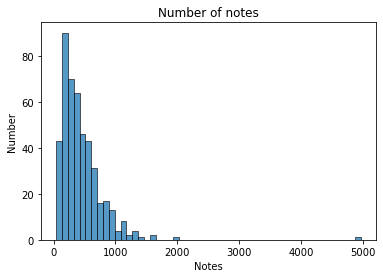

In [109]:
sns.histplot(df['number of notes'].dropna(), kde=False) 
plt.title('Number of notes')
plt.xlabel('Notes')
plt.ylabel('Number')
plt.show()

In [110]:
df = df[df['number of notes'] < 2000]

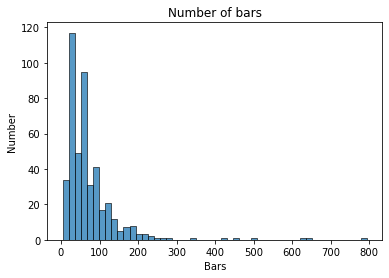

In [111]:
sns.histplot(df['number of bars'].dropna(), kde=False) 
plt.title('Number of bars')
plt.xlabel('Bars')
plt.ylabel('Number')
plt.show()

In [112]:
df = df[df['number of bars'] < 400]

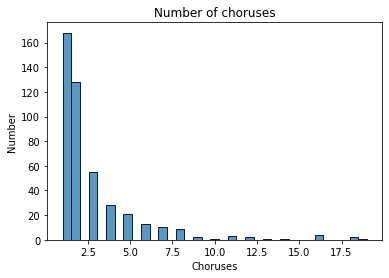

In [113]:
sns.histplot(df['number of choruses'].dropna(), kde=False) 
plt.title('Number of choruses')
plt.xlabel('Choruses')
plt.ylabel('Number')
plt.show()

In [114]:
df = df[df['number of choruses'] < 15.0]

After removing the outliers the dataset is all cleaned and ready to be used for various exploratory data analysises

<i>Sidenote:<br>
As mentioned above in the function, there are two rows with a NaN in them. I decided not to remove them, as the dataset itself is not that big so I want to use all I can. The NaNs are also not for the whole song row, but just one category</i>

<hr>

## Exploratory Data Analysis

I have a total of 27 columns, it is important to figure out the best variables that will help for my design problem. I did this in three ways<br>

<ol>
<li>received feedback lecturer: look at <font color='purple'><i>instruments</i></font> and <font color='purple'><i> style</i></font></li>
<li>asking a musical sister to look at my columns and ask what best distinguishes music from each other, or combines music with each other in the same group: <font color='purple'><i>instruments, style/groove/feel, tempo notes/s/bar, bars and tones, and a little bit syncopicity</i></font></li>
<li>lastly, I looked online to figure out what is the best indicator for jazz music: <font color='purple'><i>rhythm, improvisation, harmony, notes how high and low, instruments, and complexity chords</i> </font><br><font color='blue'>http://home.olemiss.edu/~rvernon/mus103/summary/jazz.html<br>https://www.washingtonpost.com/lifestyle/style/all-about-jazz-a-unique-form-of-american-music/2012/05/24/gJQA4bswnU_story.html<br>
    https://en.wikipedia.org/wiki/Jazz</font></li>
<br><br>
    </ol>

In conclusion, it can be seen that instruments and style are reaccuring themes in all three. One of these could be the dependent variable, This will be found out in the next part.<br><br> <b>But first, why am I doing this exploratory data analysis?</b><br>
I could just collect all the same instruments songs from the site and be done with it.
<br>
Before downloading midi's, I first want to delve even deeper into the dataset. I want to use exploratory data analysis to figure out which independent variables have patterns with the dependent and more importantly which don't. Now why am I focusing on the don't. To give a rough example explanation: if our dependent variable is a specific instrument like 'cl', and then I take all of those MIDI's with 'cl', then it could contain a song with a slow tempo, a few notes with a swing style and it could contain a song with a high tempo, many notes and a cool style. They both have the same instruments, but still differ a lot.<br>
When I for example look at 'cl' and extrema ratio (%), it can perhaps show that all 'cl' songs contain a ratio lower than 25%, then there is a pattern there and the songs are similar. I could then perhaps remove the outliers that are above 25%.
<br><br>


The overall take of this is; I want to discover unpatternable independent variables that will present the outliers in the overall dependent value. I then plan to scrap those outliers from the midi's so that they are even more similar with each other. I do all this in order to make the generative model work better, as the more similar the songs are, the better results it will give.
<br><br>

I am aware that I don't have the biggest dataset, so I have to take the range in account. The songs of course will be different in multiple aspects, but if I can remove even a little difference in them, then that is enough. In the end, I want to have found around 100+ jazz songs that are pretty related with each other so that the generative model can work well.

I already talked about the term, but a dependent variable is the effect. Its value depends on changes in the independent variables.<br>
From research and feedback they are the big identifiers for the jazz category.
<br><br>
First, I want to look at their quantities for the most popular one, as quantity plays a major role, the more MIDI files, the better.

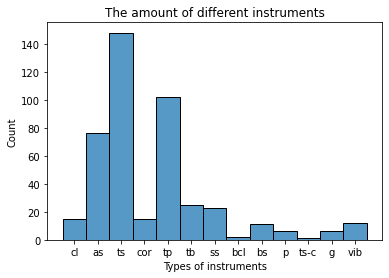

In [115]:
sns.histplot(df['instrument'].dropna(), kde=False)
plt.title('The amount of different instruments')
plt.xlabel('Types of instruments')
plt.ylabel('Count')
plt.show()

In [116]:
print(df['instrument'].describe())

count     442
unique     13
top        ts
freq      148
Name: instrument, dtype: object


A clear winner with around 148 is 'ts', with follow up's being 'tp' and 'as'

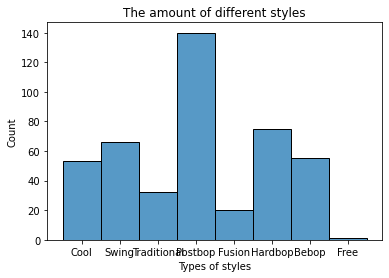

In [117]:
sns.histplot(df['style'].dropna(), kde=False)
plt.title('The amount of different styles')
plt.xlabel('Types of styles')
plt.ylabel('Count')
plt.show()

In [118]:
print(df['style'].describe())

count         442
unique          8
top       Postbop
freq          140
Name: style, dtype: object


A clear winner with around 140 is 'Postbop', with follow up's being 'Hardbop' and 'Swing'

They appear to have similar counts for their highest number. To discover if 'ts' and 'postbop' have patterns with other variables, I did the exploratory data analysis that will begin after this text twice, one for each. To save space, I can say that instrument was the winner, and I will continue with that one as the dependent variable.

Before I make a pairplot to look at the relationships with other variables. I shall first create dummies for instruments. I do this because we are focusing on a specific value in instruments: ts

In [119]:
dummies = pd.get_dummies(df['instrument'])
pd.get_dummies(df['instrument'])
df = pd.concat([df, dummies], axis=1)
df.head()

,row,performer,title,instrument,style,year,tempo,number of notes,duration (s),key,...,cl,cor,g,p,ss,tb,tp,ts,ts-c,vib
0,1,Art Pepper,Anthropology,cl,Cool,1979,218,530,141,Bb-maj,...,1,0,0,0,0,0,0,0,0,0
1,2,Art Pepper,Blues for Blanche,as,Cool,1979,198,666,159,Eb-maj,...,0,0,0,0,0,0,0,0,0,0
2,3,Art Pepper,Desafinado,as,Cool,1979,140,373,111,F-maj,...,0,0,0,0,0,0,0,0,0,0
3,4,Art Pepper,In a Mellow Tone,cl,Cool,1979,167,565,183,Eb-maj,...,1,0,0,0,0,0,0,0,0,0
4,5,Art Pepper,Stardust,as,Cool,1979,60,591,255,Eb-maj,...,0,0,0,0,0,0,0,0,0,0


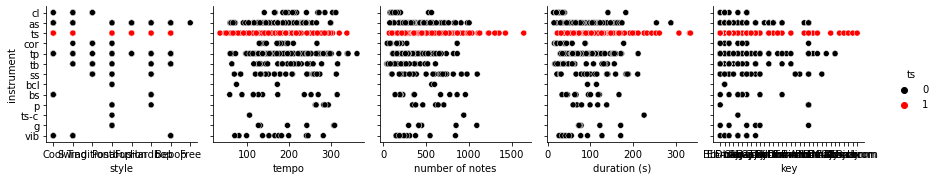

In [120]:
sns.pairplot(
    df, hue = "ts", palette=['black','red'],
    x_vars=["style", "tempo", "number of notes", "duration (s)", "key"],
    y_vars=["instrument"]
)

Conclusions:
- style -> difficult to read
- tempo -> widespread
- number of notes -> mostly on the left
- duration (s) -> mostly on the left
- key -> widespread

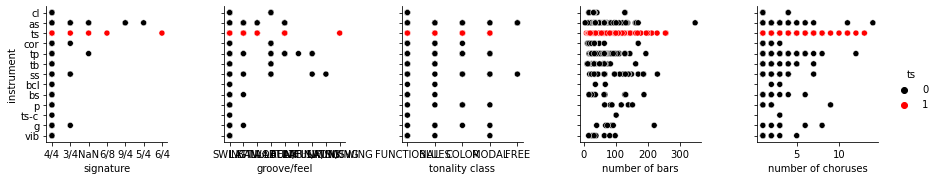

In [121]:
sns.pairplot(
    df, hue = "ts", palette=['black','red'],
    x_vars=["signature", "groove/feel", "tonality class", "number of bars", "number of choruses"],
    y_vars=["instrument"]
)

Conclusions:
- signature -> difficult to read
- groove/feel -> difficult to read
- tonality class -> difficult to read
- numbers of bars -> mostly on the left
- numbers of choruses -> difficult to read

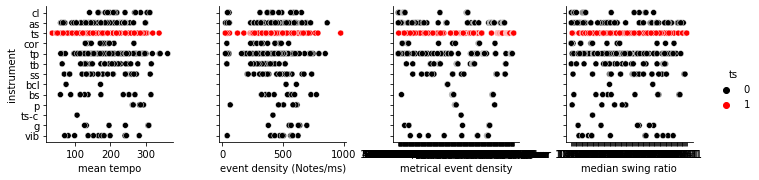

In [122]:
sns.pairplot(
    df, hue = "ts", palette=['black','red'],
    x_vars=["mean tempo", "event density (Notes/ms)", "metrical event density", "median swing ratio"],
    y_vars=["instrument"]
)

Conclusions:
- mean tempo -> widespread
- event density (Notes/ms) -> mostly in the middle
- metrical event density -> widespread
- median swing ratio -> widespread

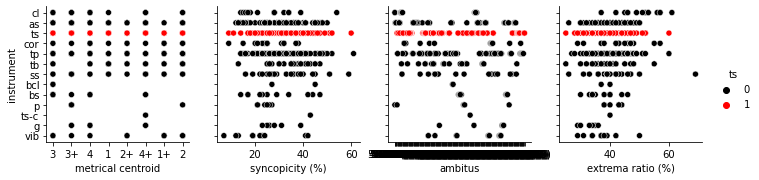

In [123]:
sns.pairplot(
    df, hue = "ts", palette=['black','red'],
    x_vars=["metrical centroid", "syncopicity (%)", "ambitus", "extrema ratio (%)"],
    y_vars=["instrument"]
)

Conclusions:
- metrical centroid -> difficult to read
- syncopicity (%) -> mostly in the middle
- ambitus -> widespread
- extrema ratio (%) -> mostly on the left

### Overall conclusion of the pairplot:

Unfortunately there was not that much relation with other variables as I had hoped to see. It was even more difficult to see with categorical variables, what was expected, but the numerical variables were in most cases pretty wide all around.<br><br>

I can conduct:
- "ts" does seem to have some relationship with variables like: event density, syncopicity and extrema ratio. As they are pretty cooked up together in a spot
- "ts" does not seem to share most noticably any relationship with variables like: tempo, metrical event density and median swing ratio

Let's check with a correlation matrix the measures of those three last variables

In [124]:
corr = df.corr()
corr["ts"] #This gets only the relevant column from the correlations

row                         0.009784
year                        0.257516
tempo                      -0.162898
number of notes             0.258948
duration (s)                0.261773
number of bars              0.109824
number of choruses          0.183318
mean tempo                 -0.162898
event density (Notes/ms)    0.023428
syncopicity (%)             0.170331
extrema ratio (%)           0.016837
tempo high                 -0.119043
tempo medium high          -0.059211
tempo medium                0.067276
tempo medium slow           0.109850
tempo slow                  0.158259
as                         -0.323313
bcl                        -0.047835
bs                         -0.113348
cl                         -0.132981
cor                        -0.132981
g                          -0.083232
p                          -0.083232
ss                         -0.166232
tb                         -0.173724
tp                         -0.388613
ts                          1.000000
t

Ignoring the other instruments, it can be seen that "tempo" has the worst correlation with the "ts" instrument. More precisely "tempo high and medium high". Let's visualise this

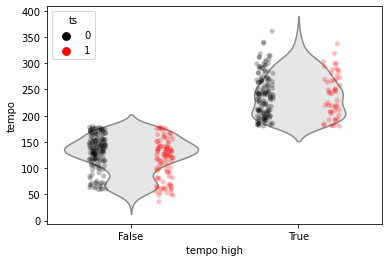

In [125]:
ax = ax = sns.violinplot(x="tempo high", y="tempo", data=df,
                         inner=None, color=".9")
ax = sns.stripplot(x="tempo high", y="tempo", hue="ts", palette=["black", "red"], 
              data=df, dodge=True, alpha=.25, zorder=1)

# source:
# https://seaborn.pydata.org/examples/index.html

It can indeed be seen that the higher the tempo, the less songs there are. The biggest party happens around a tempo of 140. After around 250 the contrast of the colours are becoming very low

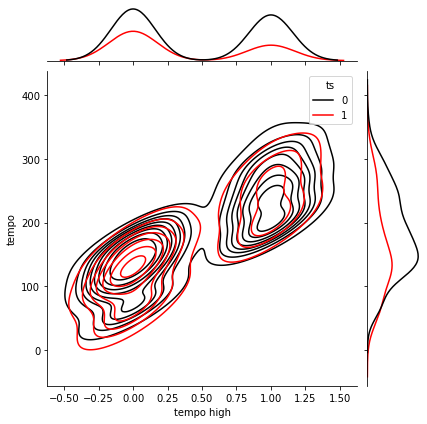

In [126]:
sns.jointplot(
    data=df, palette = ["black", "red"],
    x="tempo high", y="tempo", hue="ts",
    kind="kde")

# source:
# https://seaborn.pydata.org/examples/index.html

Another visual representation can be seen in this plot. As the red is a lot less strong in the higher "bubble" and the red line on the right shows a clear soft decline after around 140

### Overall conclusion:

I will remove the highest tempo's from 'ts' from the going to be downloaded midi songs. As can be seen, after 250 there are only a few lines and a few see-through dots. When removing these kind of small outliers, the midi songs will, even only slightly, become more the same with each other<br>
<i>I can't remove more to make them even more similar, because then I will not have enough midi files to work with when continuing</i>

In [131]:
df.loc[(df['instrument'] == 'ts') & (df['tempo'] <= 250)]

,row,performer,title,instrument,style,year,tempo,number of notes,duration (s),key,...,cl,cor,g,p,ss,tb,tp,ts,ts-c,vib
20,21,Ben Webster,Bye Bye Blackbird,ts,Swing,1959,140,451,160,G-maj,...,0,0,0,0,0,0,0,1,0,0
21,22,Ben Webster,Did You Call Her Today,ts,Swing,1962,118,424,129,Ab-maj,...,0,0,0,0,0,0,0,1,0,0
22,23,Ben Webster,My Ideal,ts,Swing,1956,74,308,103,Bb-maj,...,0,0,0,0,0,0,0,1,0,0
23,24,Ben Webster,Night and Day,ts,Swing,1956,182,375,126,D-maj,...,0,0,0,0,0,0,0,1,0,0
24,25,Ben Webster,Where or When,ts,Swing,1956,82,268,117,Ab-maj,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,452,Zoot Sims,Dancing in the Dark,ts,Cool,1950,124,110,62,Ab-maj,...,0,0,0,0,0,0,0,1,0,0
452,453,Zoot Sims,Dancing in the Dark (2),ts,Cool,1950,122,169,73,Ab-maj,...,0,0,0,0,0,0,0,1,0,0
453,454,Zoot Sims,King David,ts,Cool,1950,151,103,31,Bb-maj,...,0,0,0,0,0,0,0,1,0,0
454,455,Zoot Sims,Night and Day,ts,Cool,1950,216,359,89,D-maj,...,0,0,0,0,0,0,0,1,0,0


I will continue with 128 midi songs in the next Notebook<br>
<i> I hand downloaded them myself and put them into a folder for the next step</i>

<hr>

When using the Weimar Jazz Database:<br><br>
@Book{Pfleiderer:2017:BOOK,<br>
  title =     {{I}nside the {J}azzomat - {N}ew {P}erspectives for {J}azz  {R}esearch},<br>
  publisher = {Schott Campus},<br>
  year =      {2017},<br>
  editor =    {Pfleiderer, Martin and Frieler, Klaus and Abe{\ss}er, Jakob and Zaddach, Wolf-Georg and<br>Burkhart, Benjamin},<br>
}